In this notebook I am completing some basic time series analysis of my runs since January 2025.

The most interesting output from this current analysis for me has been regarding the seasonality of my run times, I run approximately twice a week and the data appears to show monthly seasonality. It is rare for my run time to continuously improve. After a pb my next run is usually slower.

In [1]:
import pandas as pd
running_data = pd.read_csv('running_data.csv')
running_data['Date'] = pd.to_datetime(running_data['Date'],dayfirst=True)
running_data['Duration'] = pd.to_timedelta(running_data['Duration'])
running_data['Duration'] = running_data['Duration'].dt.total_seconds()
running_data['Distance (KM)'] = running_data['Distance (KM)'].apply(lambda x: float(x))
running_data['Time/Distance (s/KM)'] = running_data.apply(lambda x: x['Duration']/x['Distance (KM)'],axis=1)
running_data['Time/Distance (min/KM)'] = running_data.apply(lambda x: x['Time/Distance (s/KM)']/60,axis=1)

In [2]:
print(running_data)

         Date Time of Day Route Location  Distance (KM)  Duration  \
0  2025-01-02    15:19:00              A           5.26    2260.0   
1  2025-01-11    09:09:00              K           4.16    1533.0   
2  2025-01-15    18:49:00              B           9.49    4260.0   
3  2025-01-18    09:24:00              C           2.62     974.0   
4  2025-01-25    09:19:00              C           5.63    2278.0   
5  2025-01-29    18:40:00              B          10.82    4020.0   
6  2025-02-01    09:09:00              D           5.09    1884.0   
7  2025-02-08    09:08:00              E           5.05    2023.0   
8  2025-02-12    18:50:00              B           9.36    3900.0   
9  2025-02-15    09:05:00              F           5.11    1924.0   
10 2025-02-23    10:35:00              G          10.59    3900.0   
11 2025-03-01    09:09:00              E           5.04    2074.0   
12 2025-03-08    09:02:00              H           5.09    2009.0   
13 2025-03-15    09:06:00         

Before decomposing the time series data we check for any significant outliers using the z score

In [3]:
running_data['Time/Distance (min/KM) Rolling Mean'] = running_data['Time/Distance (min/KM)'].rolling(3).mean()
running_data['Time/Distance (min/KM) Rolling Standard Deviation'] = running_data['Time/Distance (min/KM)'].rolling(3).std()

running_data['Time/Distance (min/KM) Rolling Mean'] = running_data['Time/Distance (min/KM) Rolling Mean'].fillna(0)
running_data['Time/Distance (min/KM) Rolling Standard Deviation'] = running_data['Time/Distance (min/KM) Rolling Standard Deviation'].fillna(0)

running_data['z score'] = running_data.apply(lambda x: (x['Time/Distance (min/KM)']-x['Time/Distance (min/KM) Rolling Mean'])/x['Time/Distance (min/KM) Rolling Standard Deviation'] if x['Time/Distance (min/KM) Rolling Mean']!=0 else 0,axis=1)

running_data['outlier?'] = running_data.apply(lambda x: 'Yes' if x['z score']<-3 or x['z score']>3 else 'No',axis=1)

outliers = running_data[running_data['outlier?']=='Yes']
print(len(outliers))

0


No significant outliers

Now we will use seasonal decomposition to detect the trend, seasonal and residual components

The seasonality in the data is approximately monthly and there is approximately 2 runs a week recorded so we will use a period of 4 (weeks) * 2 = 8

In [4]:
import numpy as np
model_input = pd.Series(np.array(running_data['Time/Distance (min/KM)']),index=running_data['Date'])

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(model_input,model='additive',period=8)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

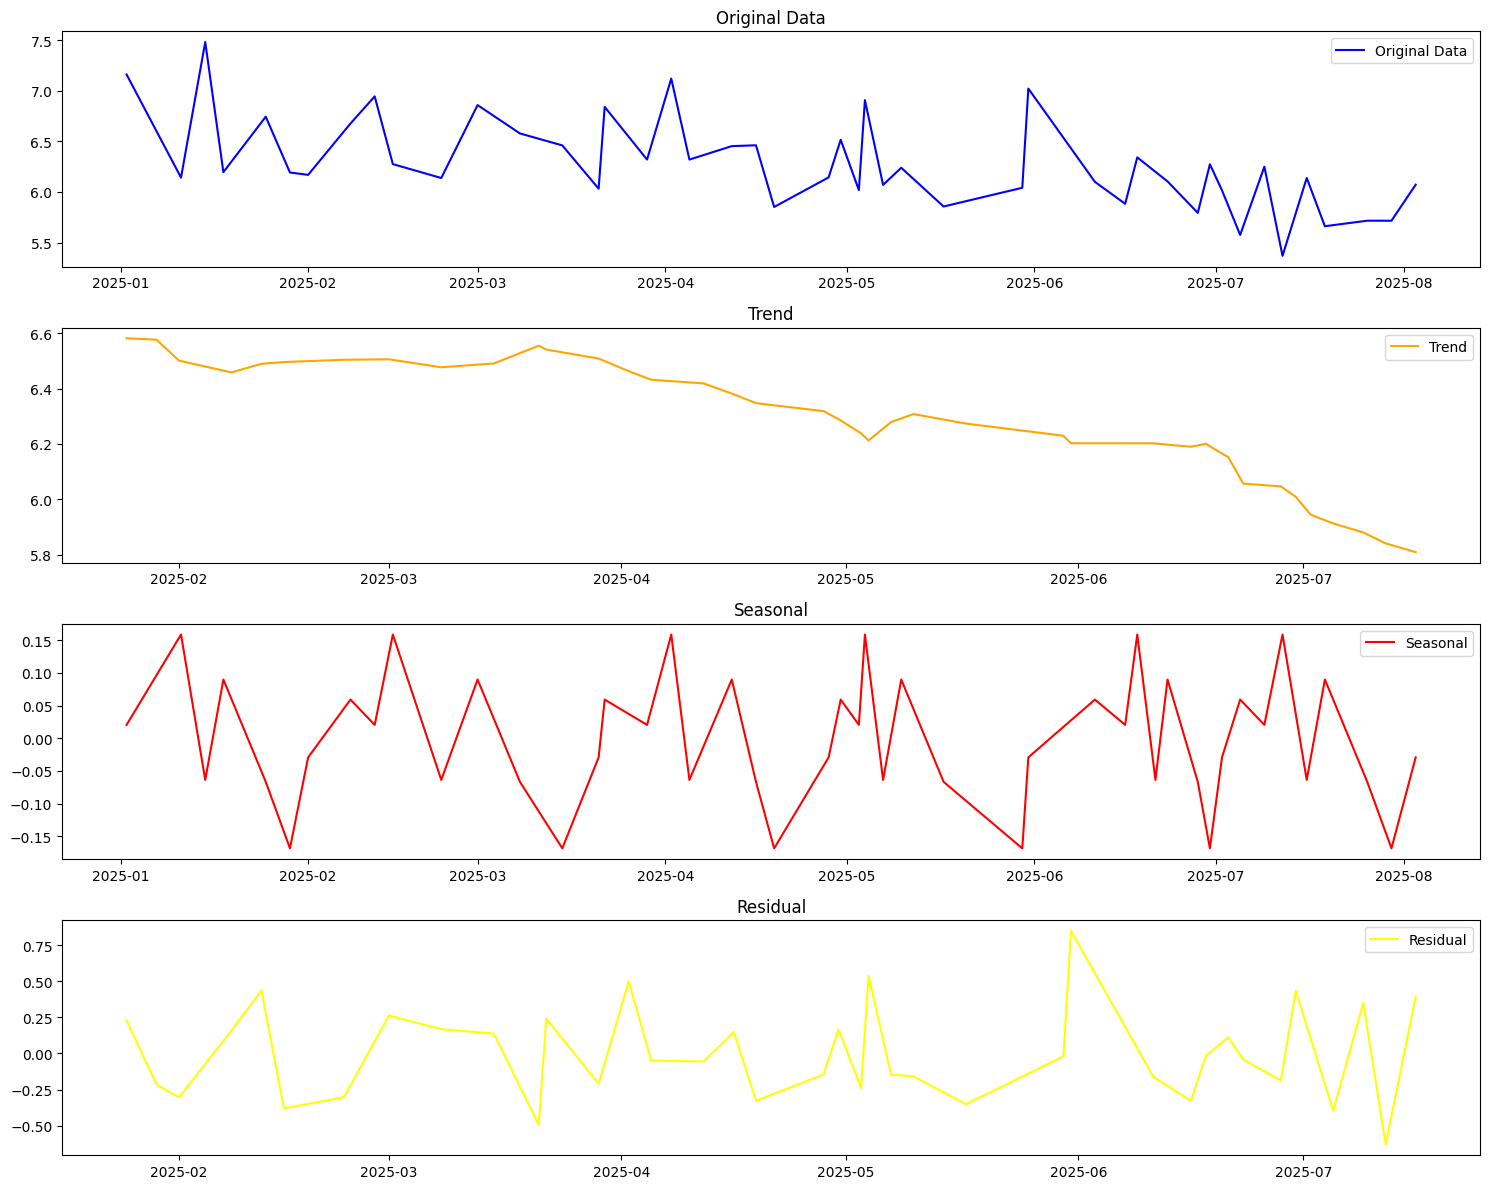

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.plot(model_input,label='Original Data',color='blue')
plt.title('Original Data')
plt.legend()
plt.subplot(4,1,2)
plt.plot(trend,label='Trend',color='orange')
plt.title('Trend')
plt.legend()
plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonal',color='red')
plt.title('Seasonal')
plt.legend()
plt.subplot(4,1,4)
plt.plot(residual,label='Residual',color='yellow')
plt.title('Residual')
plt.legend()
plt.tight_layout()
plt.show()